In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import keras
import tensorflow

from keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg19 import VGG19,preprocess_input,decode_predictions

from tensorflow.keras.utils import img_to_array

from keras_preprocessing.image import load_img

In [3]:
train_datagen = ImageDataGenerator(zoom_range=0.5,shear_range=0.3,horizontal_flip=True,preprocessing_function= preprocess_input)
val_datagen = ImageDataGenerator(rescale= 1/255)

In [4]:
x_train=train_datagen.flow_from_directory(r'/content/drive/MyDrive/Dataset Plant Disease/fruit-dataset/test',target_size=(256,256),class_mode='categorical',batch_size=32)
x_val=val_datagen.flow_from_directory(r'/content/drive/MyDrive/Dataset Plant Disease/fruit-dataset/train',target_size=(256,256),class_mode='categorical',batch_size=32)

Found 1686 images belonging to 6 classes.
Found 5394 images belonging to 6 classes.


In [5]:
from keras.layers import Dense, Flatten 
from keras.models import Model
from keras.applications.vgg19 import VGG19
import keras

In [6]:
base_model = VGG19(input_shape=(256, 256, 3), include_top = False)

80134624/80134624 [==============================] - 4s 0us/step


In [7]:
for layer in base_model.layers:
  layer.trainable= False

In [8]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [9]:
X = Flatten()(base_model.output)
X= Dense(units = 6, activation='softmax')(X)

#creating our model
model = Model(base_model.input, X)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [10]:
import tensorflow as tf
tf.keras.losses.CategoricalCrossentropy()
loss = 'categorical_crossentropy'
model.compile(optimizer= 'adam', loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es= EarlyStopping(monitor= 'val_accuracy',min_delta=0.01, patience = 3, verbose = 1)

#model check point
mc= ModelCheckpoint(filepath ="fruit_model.h5", 
                    monitor= 'val_accuracy', 
                    min_delta=0.01, 
                    patience= 3, 
                    verbose = 1, 
                    save_best_only= True)
cb= [es, mc]

In [12]:
his= model.fit_generator(x_train, steps_per_epoch = 16, epochs= 50, verbose= 1, callbacks= cb, validation_data= x_val, validation_steps = 16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 4.4297 - accuracy: 0.7070 
Epoch 1: val_accuracy improved from -inf to 0.38477, saving model to fruit_model.h5
16/16 [==============================] - 906s 57s/step - loss: 4.4297 - accuracy: 0.7070 - val_loss: 2.5263 - val_accuracy: 0.3848
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 0.9674 - accuracy: 0.9183 
Epoch 2: val_accuracy improved from 0.38477 to 0.66016, saving model to fruit_model.h5
16/16 [==============================] - 889s 57s/step - loss: 0.9674 - accuracy: 0.9183 - val_loss: 1.4509 - val_accuracy: 0.6602
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 0.9224 - accuracy: 0.9434 
Epoch 3: val_accuracy improved from 0.66016 to 0.66211, saving model to fruit_model.h5
16/16 [==============================] - 887s 57s/step - loss: 0.9224 - accuracy: 0.9434 - val_loss: 1.6496 - val_accuracy: 0.6621
Epoch 4/50
16/16 [==============================] - ETA: 0s - lo

In [13]:
h= his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

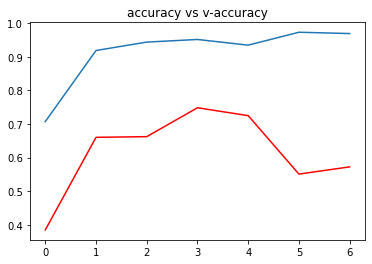

In [14]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c= "red")
plt.title("accuracy vs v-accuracy")
plt.show()

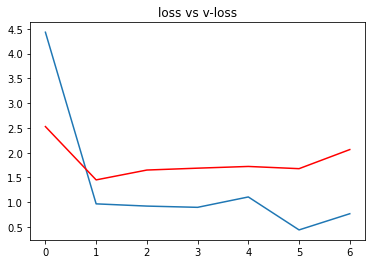

In [15]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c= "red")
plt.title("loss vs v-loss")
plt.show()

In [16]:
#load best model
from keras.models import load_model
model= load_model("/content/fruit_model.h5")

In [17]:
def prediction(path):
  img= load_img(path,target_size=(256, 256))
  i=img_to_array(img)
  im=preprocess_input(i)
  img= np.expand_dims(im, axis=0)
  pred = np.argmax(model.predict(img))
  ref = dict(zip(list(x_train.class_indices.values()) , list(x_train.class_indices.keys())))
  print(f" the image belongs to {ref[pred]}")

In [18]:
ref = dict(zip(list(x_train.class_indices.values()) , list(x_train.class_indices.keys())))

In [21]:
#prediction of images into numbers
path = "/content/drive/MyDrive/Dataset Plant Disease/fruit-dataset/test/Corn_(maize)___Northern_Leaf_Blight/008d9af0-7568-4a67-bb1a-0e915836ddc0___RS_NLB 4165 copy 2.jpg"
prediction(path)

1/1 [==============================] - 1s 877ms/step
 the image belongs to Corn_(maize)___Northern_Leaf_Blight
